import sys
!{sys.executable} -m pip install vaderSentiment


In [2]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER so we can use it later
sentimentAnalyser = SentimentIntensityAnalyzer()

In [4]:
import pandas as pd
pd.options.display.max_colwidth = 400

In [6]:
# test a sentence
sentimentAnalyser.polarity_scores("I like the Marvel movies")

{'neg': 0.0, 'neu': 0.361, 'pos': 0.639, 'compound': 0.6486}

In [12]:
# 1. Load all .txt files from the folder

import os

# Path to the folder of news articles
folder_path = '../../1_Datacollection/Corpus_deepseek'

# List all .txt files in the folder
file_names = [f for f in os.listdir(folder_path) if f.endswith('.txt')]

# Read each file
texts = []
file_ids = []

for file_name in file_names:
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()
        texts.append(content)
        file_ids.append(file_name)  # Keep track of which file is which

In [14]:
# 2. Run VADER sentiment analysis on each article

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

sentiments = []
for text in texts:
    score = analyzer.polarity_scores(text)
    sentiments.append(score)


In [15]:
# 3. combine into one dataframe

import pandas as pd

df = pd.DataFrame({
    'filename': file_ids,
    'text': texts,
    'sentiment': sentiments
})

# Optional: Extract compound sentiment score
df['compound'] = df['sentiment'].apply(lambda x: x['compound'])

# Preview the results
print(df[['filename', 'compound']].head())


                                                 filename  compound
0  What_is_DeepSeek,_the_Chinese_AI_startup_that_shoo.txt    0.9984
1  Chinese_AI_disrupter_DeepSeek_claims_top_spot_in_U.txt    0.8481
2       Which_countries_have_banned_DeepSeek_and_why?.txt    0.8846
3               Global_AI_rivalry_is_a_dangerous_game.txt   -0.8705
4  DeepSeek_just_blew_up_the_AI_industry’s_narrative_.txt    0.9271


In [18]:
# 4. save to CSV
df.to_csv('../outputs/deepseek_vadersentiment_results.csv', index=False)


Plot Sentiment Over Time
We can plot how texts’ sentiment fluctuates over time
✅ Goal:
I want to plot sentiment over time, grouped by source (e.g., newspaper), using:

Sentiment scores from .txt files

Metadata (source + date) from your CSV

✅ Assumptions:
Each .txt file is a news article with a filename like title1.txt, title2.txt, etc.

The metadata CSV has at least:

A filename column (e.g., title1.txt)

A source column (e.g., BBC, CNN)

A date column (e.g., 2023-06-01), though some dates are missing.

In [20]:
# step 1
import pandas as pd

# Load data from two csv files
sentiment_df = pd.read_csv("../outputs/deepseek_vadersentiment_results.csv")
meta_df = pd.read_csv("../../1_Datacollection/metadata_all_texts_complete.csv") 
#There are missing dates in metadata,so it needs to be completed
print(sentiment_df.head())
print(meta_df.head())


                                                 filename  \
0  What_is_DeepSeek,_the_Chinese_AI_startup_that_shoo.txt   
1  Chinese_AI_disrupter_DeepSeek_claims_top_spot_in_U.txt   
2       Which_countries_have_banned_DeepSeek_and_why?.txt   
3               Global_AI_rivalry_is_a_dangerous_game.txt   
4  DeepSeek_just_blew_up_the_AI_industry’s_narrative_.txt   

                                                                                                                                                                                                                                                                                                                                                                                                              text  \
0  CNN —\n\nA surprisingly efficient and powerful Chinese AI model has taken the technology industry by storm. It’s called DeepSeek R1, and it’s rattling nerves on Wall Street.\n\nThe new AI model was developed by DeepSeek, a s

In [32]:
# step 2
# Merge two csv files on 'filename'
merged_df = pd.merge(sentiment_df, meta_df, on="filename")

# Convert date column
merged_df['date'] = pd.to_datetime(merged_df['date'])


In [34]:
# step 3: Group and Plot
# Option A: Use Altair

import altair as alt

grouped = merged_df.groupby(['date', 'source'])['compound'].mean().reset_index()

chart = alt.Chart(grouped).mark_line(point=True).encode(
    x='date:T',
    y='compound:Q',
    color='source:N',
    tooltip=['date:T', 'source:N', 'compound:Q']
).properties(
    title='Sentiment Over Time by Source',
    width=800,     # ⬅️ expand width here (default is ~400)
    height=400     # ⬅️ optional
)

chart.display()


alt.Chart(...)

In [36]:
chart.save('../visualizations/sentiment_over_time.html')

In [39]:
# zoom in on particular time period
chart_interactive = alt.Chart(grouped).mark_line(point=True).encode(
    x=alt.X('date:T', scale=alt.Scale(domain=('2025-01-26', '2025-02-23'))),  # initial zoom range
    y='compound:Q',
    color='source:N',
    tooltip=['date:T', 'source:N', 'compound:Q']
).properties(
    title='Interactive Sentiment Chart (Initial Zoom: Jan 26 – Feb 23)',
    width=800,
    height=400
).interactive()  # Enables zooming and panning

chart_interactive.display()


alt.Chart(...)

 Observations (summarized):
Most sentiment scores are between 0.0 and 1.0 → generally positive.
High density of articles between Jan 26 and Feb 23 → suggests an important event (likely stock-related).
Many articles have strong positive sentiment (0.6–1.0).
A few articles have very negative sentiment (≤ -0.8) → potential outliers or critical views.

import sys
!{sys.executable} -m pip install matplotlib

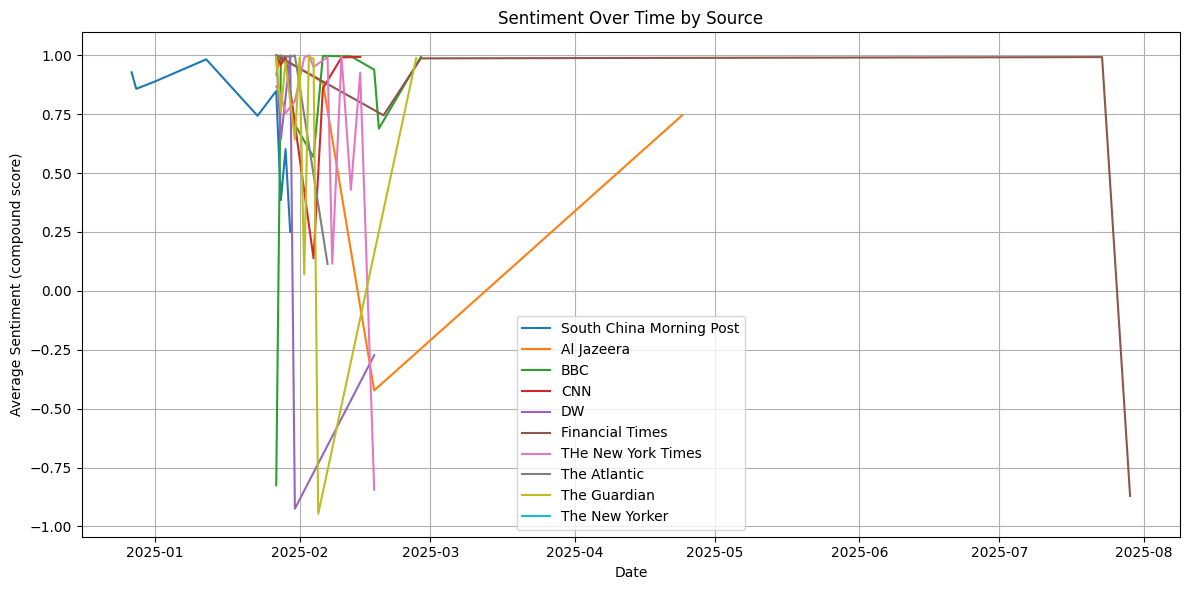

In [43]:
# option B this could be conducted in another enviroment
import matplotlib.pyplot as plt

grouped = merged_df.groupby(['date', 'source'])['compound'].mean().reset_index()

plt.figure(figsize=(12, 6))

for source in grouped['source'].unique():
    subset = grouped[grouped['source'] == source]
    plt.plot(subset['date'], subset['compound'], label=source)

plt.title('Sentiment Over Time by Source')
plt.xlabel('Date')
plt.ylabel('Average Sentiment (compound score)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save before showing
plt.savefig('../visualizations/sentiment_over_time.png', dpi=300)  # PNG


plt.show()


In [54]:
# Find articles with negative sentiment
negative = merged_df[merged_df['compound'] < 0]

# Show their filenames, sources, dates, and compound scores
negative[['filename', 'source', 'date', 'compound']]

,filename,source,date,compound
3,Global_AI_rivalry_is_a_dangerous_game.txt,Financial Times,2025-07-29,-0.8705
11,What_questions_will_China's_DeepSeek_not_answer?_–.txt,DW,2025-01-31,-0.9249
21,DeepSeek:_Is_China's_AI_tool_as_good_as_it_seems?.txt,BBC,2025-01-27,-0.8249
32,First_Thing:_Donald_Trump_calls_China’s_DeepSeek_A.txt,The Guardian,2025-01-28,-0.3313
42,"South_Korea_Bans_Downloads_of_DeepSeek,_the_Chines.txt",THe New York Times,2025-02-17,-0.8442
50,DeepSeek’s_tech_breakthrough_hailed_in_China_as_an.txt,South China Morning Post,2025-01-28,-0.7506
63,DeepSeek_has_ripped_away_AI’s_veil_of_mystique._Th.txt,The Guardian,2025-02-02,-0.8572
84,DeepSeek:_South_Korea_temporarily_bans_AI_app_–_DW.txt,DW,2025-02-17,-0.2732
104,South_Korea_removes_DeepSeek_from_app_stores_pendi.txt,Al Jazeera,2025-02-17,-0.4228
108,US_tech_stocks_plunge_on_China_AI’s_unexpectedly_s.txt,South China Morning Post,2025-01-28,-0.6943


In [56]:
# Select specific columns
negative_subset = negative[['filename', 'source', 'date', 'compound','text']]

# Save to CSV
negative_subset.to_csv('../outputs/negative_texts.csv', index=False)

In [22]:
import os
import shutil
import pandas as pd

# Step 1: List of filenames to include
# Read the CSV
df = pd.read_csv("../outputs/negative_texts.csv")

# Extract the 'filename' column as a list
filenames = df['filename'].tolist()


# Step 2: Set up paths
source_folder = "../../1_Datacollection/Corpus_deepseek"              # change this to the source folder
destination_folder = "../negative_DeepSeek_texts"    # name of the new folder

# Step 3: Create destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Step 4: Copy matching files to the new folder
for filename in filenames:
    source_path = os.path.join(source_folder, filename)
    destination_path = os.path.join(destination_folder, filename)
    
    try:
        shutil.copy(source_path, destination_path)
        print(f"Copied: {filename}")
    except FileNotFoundError:
        print(f"❌ File not found: {filename}")


Copied: Global_AI_rivalry_is_a_dangerous_game.txt
Copied: What_questions_will_China's_DeepSeek_not_answer?_–.txt
Copied: DeepSeek:_Is_China's_AI_tool_as_good_as_it_seems?.txt
Copied: First_Thing:_Donald_Trump_calls_China’s_DeepSeek_A.txt
Copied: South_Korea_Bans_Downloads_of_DeepSeek,_the_Chines.txt
Copied: DeepSeek’s_tech_breakthrough_hailed_in_China_as_an.txt
Copied: DeepSeek_has_ripped_away_AI’s_veil_of_mystique._Th.txt
Copied: DeepSeek:_South_Korea_temporarily_bans_AI_app_–_DW.txt
Copied: South_Korea_removes_DeepSeek_from_app_stores_pendi.txt
Copied: US_tech_stocks_plunge_on_China_AI’s_unexpectedly_s.txt
Copied: Diving_into_DeepSeek:_inside_the_7_February_Guardi.txt
